
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy/v0.12?urlpath=lab/tree/spectrum_simulation.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[spectrum_simulation.ipynb](../_static/notebooks/spectrum_simulation.ipynb) |
[spectrum_simulation.py](../_static/notebooks/spectrum_simulation.py)
</div>


# Spectrum simulation for CTA

A quick example how to use the functions and classes in gammapy.spectrum in order to simulate and fit spectra. 

We will simulate observations for the [Cherenkov Telescope Array (CTA)](https://www.cta-observatory.org) first using a power law model without any background. Than we will add a power law shaped background component. The next part of the tutorial shows how to use user defined models for simulations and fitting.

We will use the following classes:

* [gammapy.spectrum.SpectrumDatasetOnOff](../api/gammapy.spectrum.SpectrumDatasetOnOff.rst)
* [gammapy.spectrum.SpectrumSimulation](../api/gammapy.spectrum.SpectrumSimulation.rst)
* [gammapy.irf.load_cta_irfs](../api/gammapy.irf.load_cta_irfs.rst)
* [gammapy.spectrum.models.PowerLaw](../api/gammapy.spectrum.models.PowerLaw.rst)

## Setup

Same procedure as in every script ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from gammapy.spectrum import SpectrumSimulation
from gammapy.utils.fitting import Fit, Parameter
from gammapy.spectrum.models import PowerLaw
from gammapy.spectrum import models
from gammapy.irf import load_cta_irfs

## Simulation of a single spectrum

To do a simulation, we need to define the observational parameters like the livetime, the offset, the energy range to perform the simulation for and the choice of spectral model. This will then be convolved with the IRFs, and Poission fluctuated, to get the simulated counts for each observation.  

In [3]:
# Define simulation parameters parameters
livetime = 1 * u.h
offset = 0.5 * u.deg
# Energy from 0.1 to 100 TeV with 10 bins/decade
energy = np.logspace(-1, 2, 31) * u.TeV

In [4]:
# Define spectral model - a simple Power Law in this case
model_ref = PowerLaw(
    index=3.0,
    amplitude=2.5e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_ref)

PowerLaw

Parameters: 

	   name     value   error      unit      min max frozen
	--------- --------- ----- -------------- --- --- ------
	    index 3.000e+00   nan                nan nan  False
	amplitude 2.500e-12   nan cm-2 s-1 TeV-1 nan nan  False
	reference 1.000e+00   nan            TeV nan nan   True


### Get and set the model parameters after initialising
The model parameters are stored in the `Parameters` object on the spectal model. Each model parameter is a `Parameter` instance. It has a `value` and a `unit` attribute, as well as a `quantity` property for convenience.

In [5]:
print(model_ref.parameters)

Parameters
Parameter(name='index', value=3.0, factor=3.0, scale=1.0, unit='', min=nan, max=nan, frozen=False)
Parameter(name='amplitude', value=2.5e-12, factor=2.5e-12, scale=1.0, unit='cm-2 s-1 TeV-1', min=nan, max=nan, frozen=False)
Parameter(name='reference', value=1.0, factor=1.0, scale=1.0, unit='TeV', min=nan, max=nan, frozen=True)

covariance: 
None


In [6]:
print(model_ref.parameters["index"])
model_ref.parameters["index"].value = 2.1
print(model_ref.parameters["index"])

Parameter(name='index', value=3.0, factor=3.0, scale=1.0, unit='', min=nan, max=nan, frozen=False)
Parameter(name='index', value=2.1, factor=2.1, scale=1.0, unit='', min=nan, max=nan, frozen=False)


In [7]:
# Load IRFs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
cta_irf = load_cta_irfs(filename)

A quick look into the effective area and energy dispersion:

NDDataArray summary info
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 5371581.000 m2



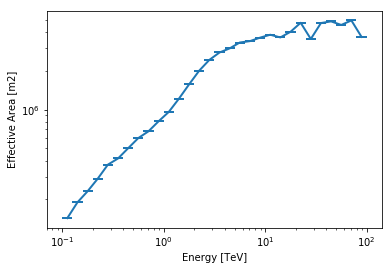

In [8]:
aeff = cta_irf["aeff"].to_effective_area_table(offset=offset, energy=energy)
aeff.plot()
plt.loglog()
print(cta_irf["aeff"].data)

NDDataArray summary info
MapAxis

	name       : e_true    
	unit       : 'TeV'     
	nbins      : 30        
	node type  : edges     
	edges min  : 1.0e-01 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       
MapAxis

	name       : e_reco    
	unit       : 'TeV'     
	nbins      : 30        
	node type  : edges     
	edges min  : 1.0e-01 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       
Data           : size =   900, min =  0.000, max =  0.926



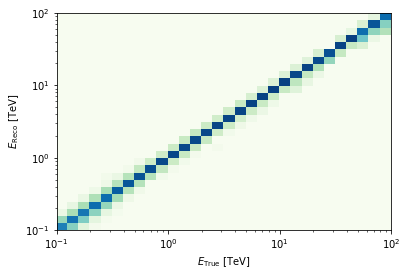

In [9]:
edisp = cta_irf["edisp"].to_energy_dispersion(
    offset=offset, e_true=energy, e_reco=energy
)
edisp.plot_matrix()
print(edisp.data)

The `SpectrumSimulation` class does the work of convolving the model with the effective area and the energy dispersion, and then Poission fluctuating the counts. An `obs_id` is needed by `SpectrumSimulation.simulate_obs()` to keep track of the simulated spectra. Here, we just pass a dummy index, but while simulating observations in a loop, this needs to be updated.

In [10]:
# Simulate data
sim = SpectrumSimulation(
    aeff=aeff, edisp=edisp, source_model=model_ref, livetime=livetime
)
sim.simulate_obs(seed=42, obs_id=0)

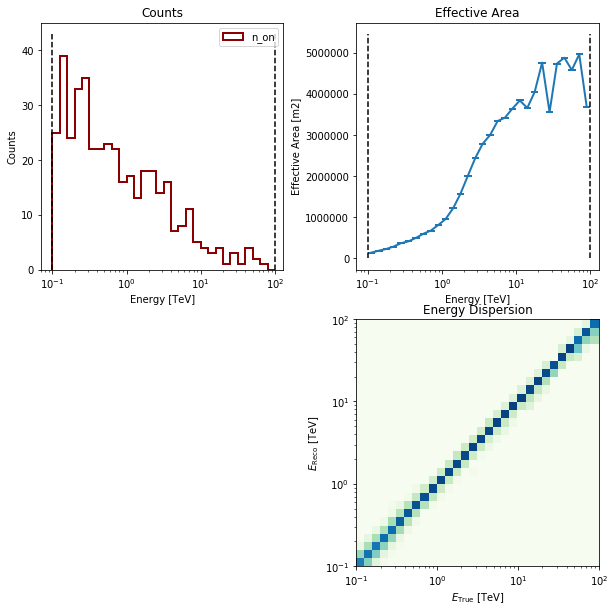

In [11]:
# Take a quick look at the simulated counts
sim.obs.peek()
print(sim.obs)

## Include Background 

In this section we will include a background component. Furthermore, we will also simulate more than one observation and fit each one individually in order to get average fit results.

In [12]:
# We assume a PowerLaw shape of the background as well
bkg_model = PowerLaw(
    index=2.5, amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)

In [13]:
%%time
# Now simulate 30 indepenent spectra using the same set of observation conditions.
n_obs = 30
seeds = np.arange(n_obs)

sim = SpectrumSimulation(
    aeff=aeff,
    edisp=edisp,
    source_model=model_ref,
    livetime=livetime,
    background_model=bkg_model,
    alpha=0.2,
)

sim.run(seeds)
print(sim.result)
print(sim.result[0])

[<gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c222e8780>, <gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c222e81d0>, <gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c222e8d30>, <gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c223fab38>, <gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c223fac18>, <gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c223faba8>, <gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c223fa470>, <gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c222e84e0>, <gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c2240a940>, <gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c2240a8d0>, <gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c2240a358>, <gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c22569b00>, <gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c225695f8>, <gammapy.spectrum.dataset.SpectrumDatasetOnOff object at 0x1c22

Before moving on to the fit let's have a look at the simulated observations.

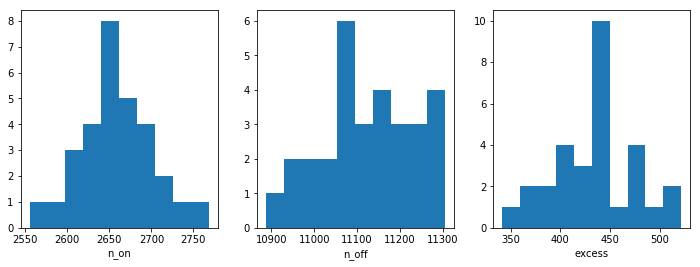

In [14]:
n_on = [obs.total_stats.n_on for obs in sim.result]
n_off = [obs.total_stats.n_off for obs in sim.result]
excess = [obs.total_stats.excess for obs in sim.result]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("n_on")
axes[1].hist(n_off)
axes[1].set_xlabel("n_off")
axes[2].hist(excess)
axes[2].set_xlabel("excess");

Now, we fit each simulated spectrum individually 

In [15]:
%%time
results = []
for obs in sim.result:
    dataset = obs
    dataset.model = model_ref.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
        }
    )

CPU times: user 2.12 s, sys: 26 ms, total: 2.15 s
Wall time: 2.22 s


We take a look at the distribution of the fitted indices. This matches very well with the spectrum that we initially injected, index=2.1

spectral index: 2.10 +/- 0.07


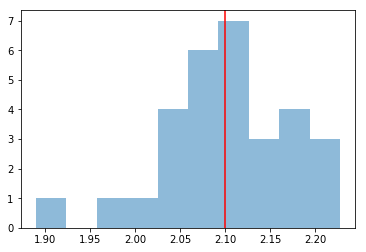

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_ref.parameters["index"].value, color="red")
print("spectral index: {:.2f} +/- {:.2f}".format(index.mean(), index.std()))

## Adding a user defined model

Many spectral models in gammapy are subclasses of `SpectralModel`. The list of available models is shown below.

In [17]:
models.SpectralModel.__subclasses__()

[gammapy.spectrum.models.ConstantModel,
 gammapy.spectrum.models.CompoundSpectralModel,
 gammapy.spectrum.models.PowerLaw,
 gammapy.spectrum.models.PowerLaw2,
 gammapy.spectrum.models.ExponentialCutoffPowerLaw,
 gammapy.spectrum.models.ExponentialCutoffPowerLaw3FGL,
 gammapy.spectrum.models.PLSuperExpCutoff3FGL,
 gammapy.spectrum.models.LogParabola,
 gammapy.spectrum.models.TableModel,
 gammapy.spectrum.models.ScaleModel,
 gammapy.spectrum.models.AbsorbedSpectralModel,
 gammapy.spectrum.models.NaimaModel,
 gammapy.spectrum.crab.MeyerCrabModel]

This section shows how to add a user defined spectral model. 

To do that you need to subclass `SpectralModel`. All `SpectralModel` subclasses need to have an `__init__` function, which sets up the `Parameters` of the model and a `static` function called `evaluate` where the mathematical expression for the model is defined.

As an example we will use a PowerLaw plus a Gaussian (with fixed width).

In [18]:
class UserModel(models.SpectralModel):
    def __init__(self, index, amplitude, reference, mean, width):
        super().__init__(
            [
                Parameter("index", index, min=0),
                Parameter("amplitude", amplitude, min=0),
                Parameter("reference", reference, frozen=True),
                Parameter("mean", mean, min=0),
                Parameter("width", width, min=0, frozen=True),
            ]
        )

    @staticmethod
    def evaluate(energy, index, amplitude, reference, mean, width):
        pwl = models.PowerLaw.evaluate(
            energy=energy,
            index=index,
            amplitude=amplitude,
            reference=reference,
        )
        gauss = amplitude * np.exp(-(energy - mean) ** 2 / (2 * width ** 2))
        return pwl + gauss

In [19]:
model = UserModel(
    index=2,
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    mean=5 * u.TeV,
    width=0.2 * u.TeV,
)
print(model)

UserModel

Parameters: 

	   name     value   error      unit         min    max frozen
	--------- --------- ----- -------------- --------- --- ------
	    index 2.000e+00   nan                0.000e+00 nan  False
	amplitude 1.000e-12   nan cm-2 s-1 TeV-1 0.000e+00 nan  False
	reference 1.000e+00   nan            TeV       nan nan   True
	     mean 5.000e+00   nan            TeV 0.000e+00 nan  False
	    width 2.000e-01   nan            TeV 0.000e+00 nan   True


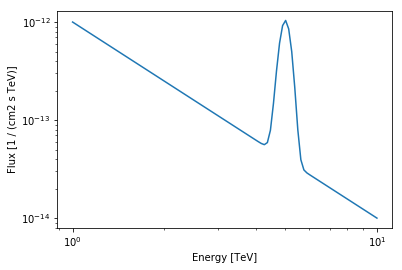

In [20]:
energy_range = [1, 10] * u.TeV
model.plot(energy_range=energy_range);

## Exercises

* Change the observation time to something longer or shorter. Does the observation and spectrum results change as you expected?
* Change the spectral model, e.g. add a cutoff at 5 TeV, or put a steep-spectrum source with spectral index of 4.0
* Simulate spectra with the spectral model we just defined. How much observation duration do you need to get back the injected parameters?

## What next?

In this tutorial we simulated and analysed the spectrum of source using CTA prod 2 IRFs.

If you'd like to go further, please see the other tutorial notebooks.